In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 102
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 64
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

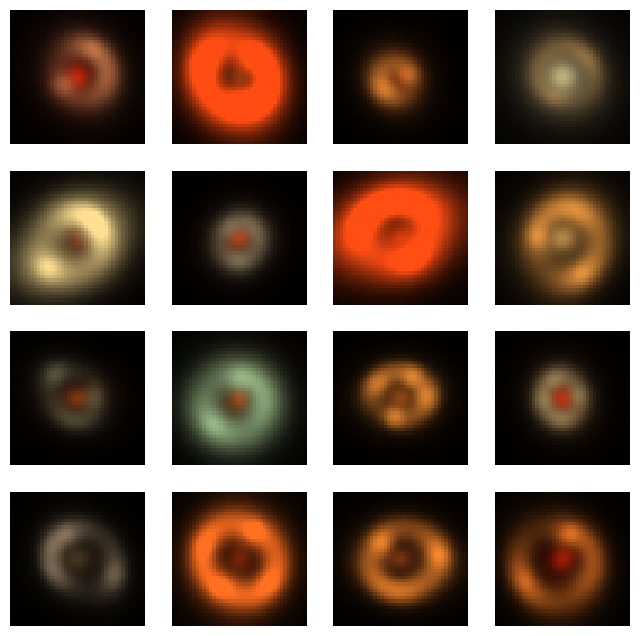

In [4]:
# Visualize source data
visualize_data(source_data)

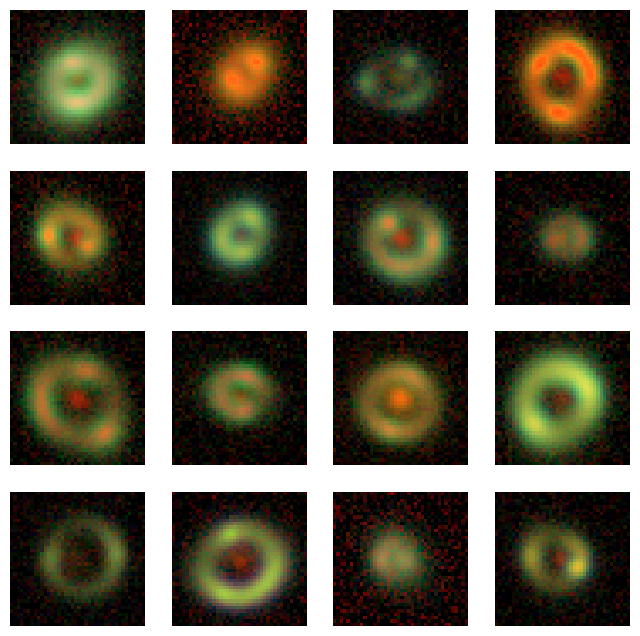

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return 0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5
n_epoch = 250
extra_epoch = n_epoch
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [7]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermvenoDA_v1_aug20_1950_A_102"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


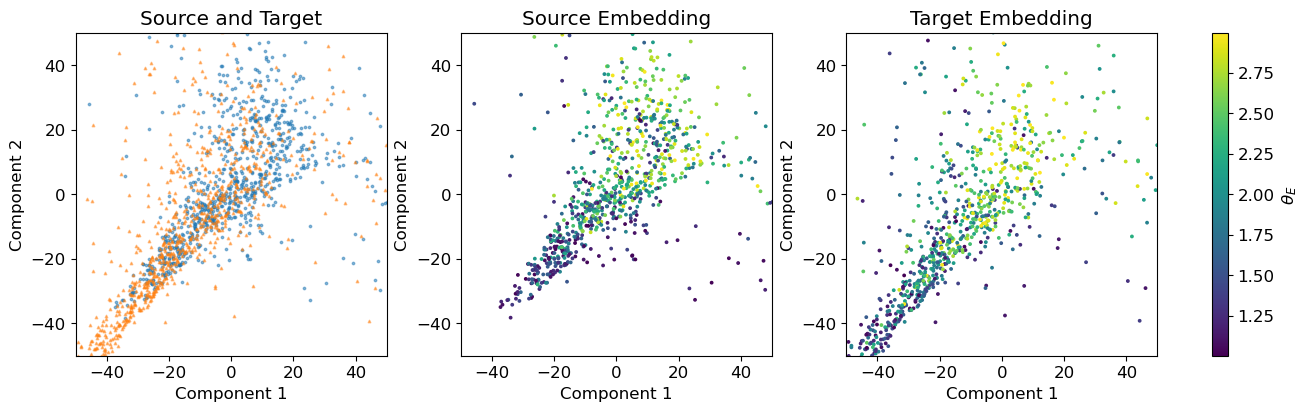


Epoch 0: 45.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2534
	Train Regression Loss: : 0.4650
	Train Mve Loss: : 0.1220
	Train R2 Score: : -0.4291
 Validation Statistics:
	Val Source Regression Loss: : 0.0426
	Val Target Regression Loss: : 0.0780
	Val Source R2 Score: : 0.8683
	Val Target R2 Score: : 0.7651
	Val Source Mve Loss: : -0.0737
	Val Target Mve Loss: : -0.0421
Saving Model... Done.
Saving Model MVE... Done.

Epoch 1: 43.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2643
	Train Regression Loss: : 0.0309
	Train Mve Loss: : -0.0624
	Train R2 Score: : 0.9054
 Validation Statistics:
	Val Source Regression Loss: : 0.0244
	Val Target Regression Loss: : 0.0598
	Val Source R2 Score: : 0.9247
	Val Target R2 Score: : 0.8202
	Val Source Mve Loss: : -0.0346
	Val Target Mve Loss: : -0.0144
Saving Model... Done.

Epoch 2: 44.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2589
	Train Regression 

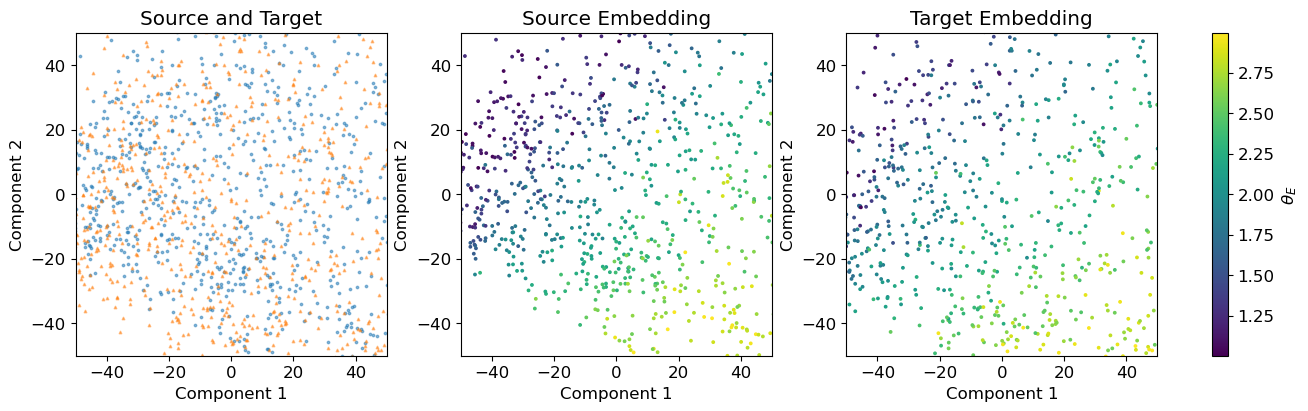

Saving Model MVE... Done.

Epoch 20: 62.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2340
	Train Regression Loss: : 0.0071
	Train Mve Loss: : -0.1013
	Train R2 Score: : 0.9781
 Validation Statistics:
	Val Source Regression Loss: : 0.0073
	Val Target Regression Loss: : 0.0512
	Val Source R2 Score: : 0.9772
	Val Target R2 Score: : 0.8456
	Val Source Mve Loss: : -0.0491
	Val Target Mve Loss: : -0.0204

Epoch 21: 64.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2305
	Train Regression Loss: : 0.0069
	Train Mve Loss: : -0.0990
	Train R2 Score: : 0.9788
 Validation Statistics:
	Val Source Regression Loss: : 0.0070
	Val Target Regression Loss: : 0.0502
	Val Source R2 Score: : 0.9780
	Val Target R2 Score: : 0.8497
	Val Source Mve Loss: : -0.1082
	Val Target Mve Loss: : -0.0855

Epoch 22: 63.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2271
	Train Regression Loss: : 0.0067
	Train Mve Loss: : -0.0726

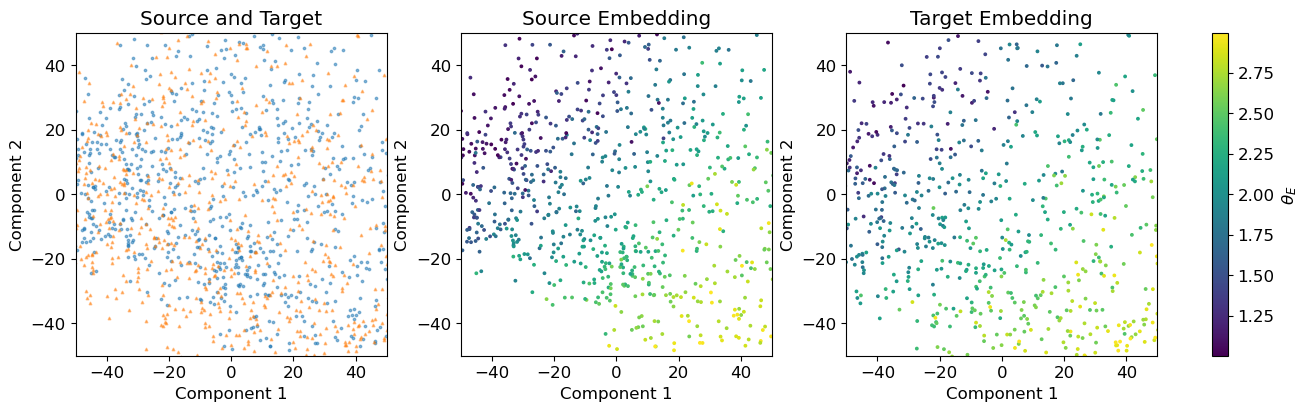

Saving Model... Done.

Epoch 40: 56.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2427
	Train Regression Loss: : 0.0040
	Train Mve Loss: : -0.0770
	Train R2 Score: : 0.9876
 Validation Statistics:
	Val Source Regression Loss: : 0.0043
	Val Target Regression Loss: : 0.0479
	Val Source R2 Score: : 0.9866
	Val Target R2 Score: : 0.8560
	Val Source Mve Loss: : -0.1971
	Val Target Mve Loss: : -0.1701
Saving Model MVE... Done.

Epoch 41: 63.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2423
	Train Regression Loss: : 0.0040
	Train Mve Loss: : -0.1741
	Train R2 Score: : 0.9876
 Validation Statistics:
	Val Source Regression Loss: : 0.0043
	Val Target Regression Loss: : 0.0446
	Val Source R2 Score: : 0.9866
	Val Target R2 Score: : 0.8655
	Val Source Mve Loss: : -0.1282
	Val Target Mve Loss: : -0.1023

Epoch 42: 61.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2430
	Train Regression Loss: : 0.0044
	Tra

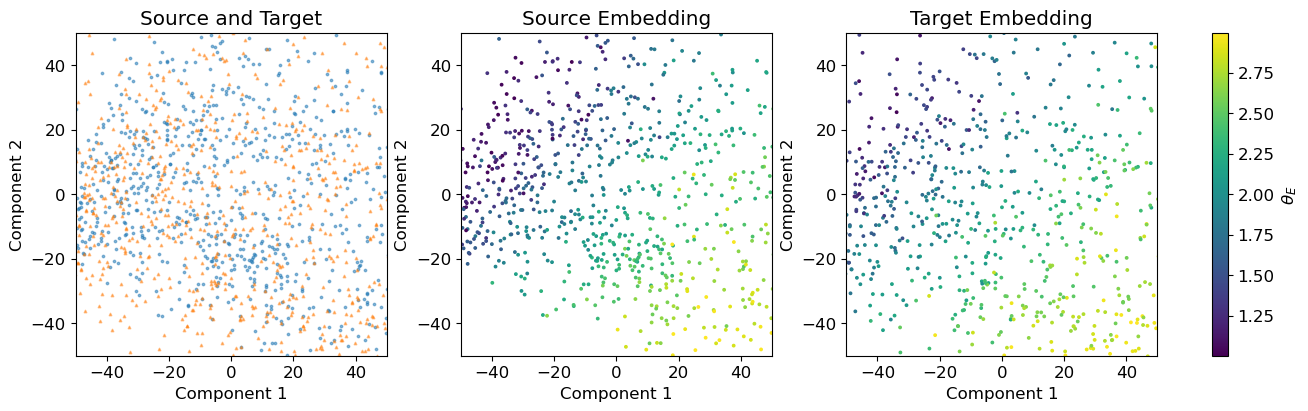

Saving Model... Done.

Epoch 60: 58.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2416
	Train Regression Loss: : 0.0034
	Train Mve Loss: : -0.1262
	Train R2 Score: : 0.9897
 Validation Statistics:
	Val Source Regression Loss: : 0.0035
	Val Target Regression Loss: : 0.0295
	Val Source R2 Score: : 0.9891
	Val Target R2 Score: : 0.9110
	Val Source Mve Loss: : -0.1328
	Val Target Mve Loss: : -0.1062
Saving Model... Done.

Epoch 61: 58.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2397
	Train Regression Loss: : 0.0036
	Train Mve Loss: : -0.1288
	Train R2 Score: : 0.9888
 Validation Statistics:
	Val Source Regression Loss: : 0.0036
	Val Target Regression Loss: : 0.0296
	Val Source R2 Score: : 0.9887
	Val Target R2 Score: : 0.9117
	Val Source Mve Loss: : -0.2007
	Val Target Mve Loss: : -0.1805
Saving Model... Done.
Saving Model MVE... Done.

Epoch 62: 62.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 

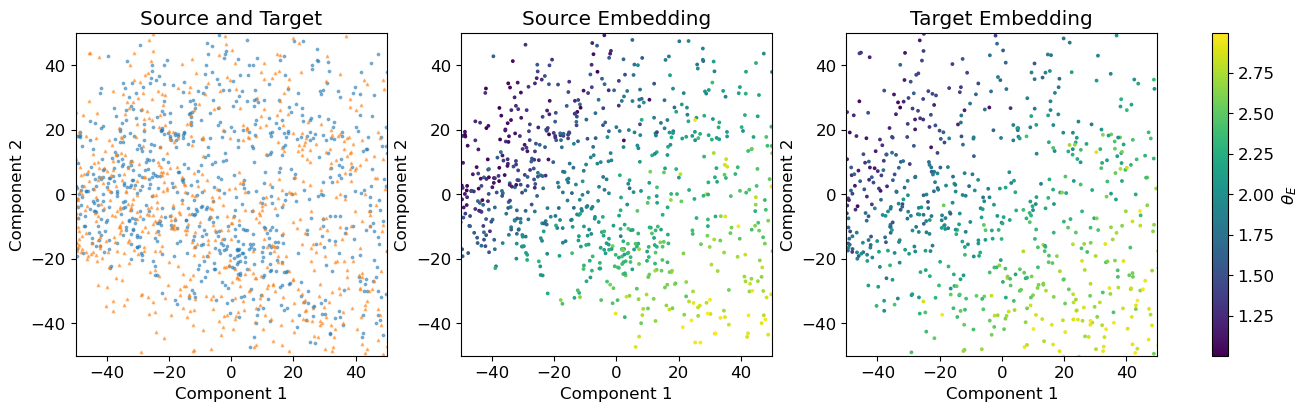


Epoch 80: 71.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2558
	Train Regression Loss: : 0.0027
	Train Mve Loss: : -0.1437
	Train R2 Score: : 0.9916
 Validation Statistics:
	Val Source Regression Loss: : 0.0028
	Val Target Regression Loss: : 0.0307
	Val Source R2 Score: : 0.9911
	Val Target R2 Score: : 0.9078
	Val Source Mve Loss: : -0.1499
	Val Target Mve Loss: : -0.1030

Epoch 81: 67.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2601
	Train Regression Loss: : 0.0027
	Train Mve Loss: : -0.1071
	Train R2 Score: : 0.9917
 Validation Statistics:
	Val Source Regression Loss: : 0.0028
	Val Target Regression Loss: : 0.0309
	Val Source R2 Score: : 0.9914
	Val Target R2 Score: : 0.9071
	Val Source Mve Loss: : -0.0665
	Val Target Mve Loss: : 0.1600

Epoch 82: 64.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2581
	Train Regression Loss: : 0.0026
	Train Mve Loss: : -0.0727
	Train R2 Score: : 0.9920


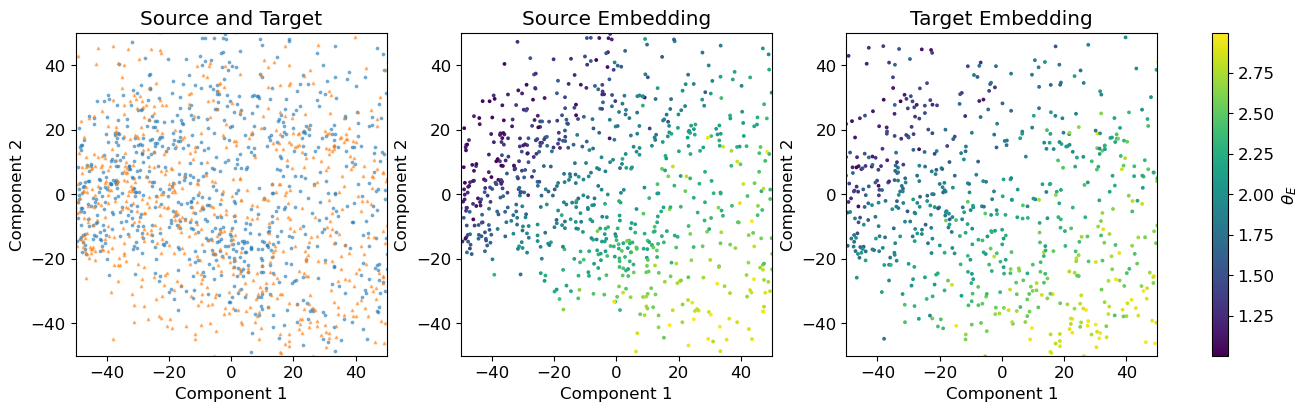


Epoch 100: 62.83s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2566
	Train Regression Loss: : 0.0024
	Train Mve Loss: : -0.1807
	Train R2 Score: : 0.9927
 Validation Statistics:
	Val Source Regression Loss: : 0.0025
	Val Target Regression Loss: : 0.0321
	Val Source R2 Score: : 0.9923
	Val Target R2 Score: : 0.9035
	Val Source Mve Loss: : -0.2401
	Val Target Mve Loss: : -0.1835
Saving Model MVE... Done.

Epoch 101: 59.64s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2548
	Train Regression Loss: : 0.0024
	Train Mve Loss: : -0.1716
	Train R2 Score: : 0.9926
 Validation Statistics:
	Val Source Regression Loss: : 0.0025
	Val Target Regression Loss: : 0.0303
	Val Source R2 Score: : 0.9923
	Val Target R2 Score: : 0.9083
	Val Source Mve Loss: : -0.1527
	Val Target Mve Loss: : -0.0889

Epoch 102: 64.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2590
	Train Regression Loss: : 0.0025
	Train Mve Loss: : -0.2

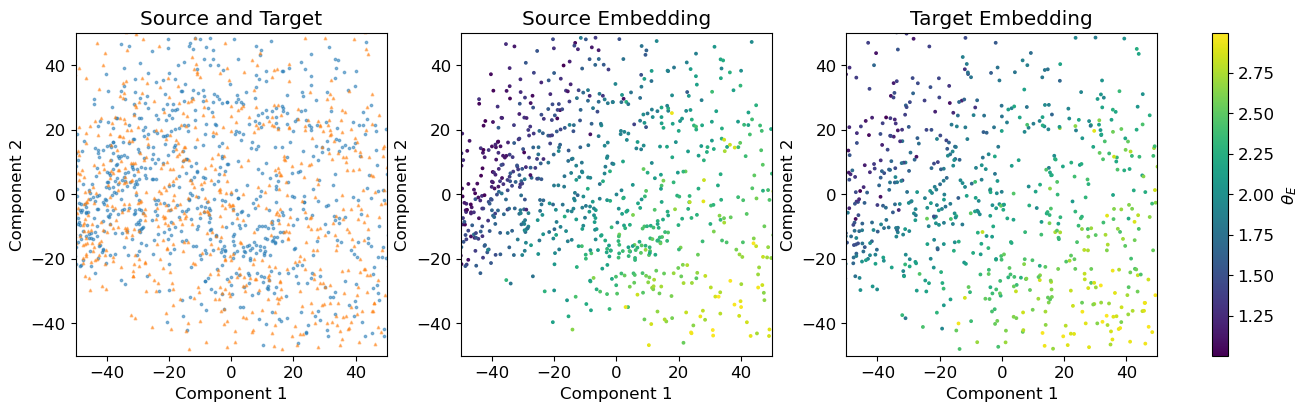


Epoch 120: 57.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2722
	Train Regression Loss: : 0.0026
	Train Mve Loss: : -0.2723
	Train R2 Score: : 0.9920
 Validation Statistics:
	Val Source Regression Loss: : 0.0031
	Val Target Regression Loss: : 0.0283
	Val Source R2 Score: : 0.9904
	Val Target R2 Score: : 0.9150
	Val Source Mve Loss: : -0.2951
	Val Target Mve Loss: : -0.2239

Epoch 121: 55.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2724
	Train Regression Loss: : 0.0025
	Train Mve Loss: : -0.2639
	Train R2 Score: : 0.9924
 Validation Statistics:
	Val Source Regression Loss: : 0.0025
	Val Target Regression Loss: : 0.0287
	Val Source R2 Score: : 0.9923
	Val Target R2 Score: : 0.9139
	Val Source Mve Loss: : -0.2178
	Val Target Mve Loss: : 1.1028

Epoch 122: 63.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2703
	Train Regression Loss: : 0.0023
	Train Mve Loss: : -0.2223
	Train R2 Score: : 0.99

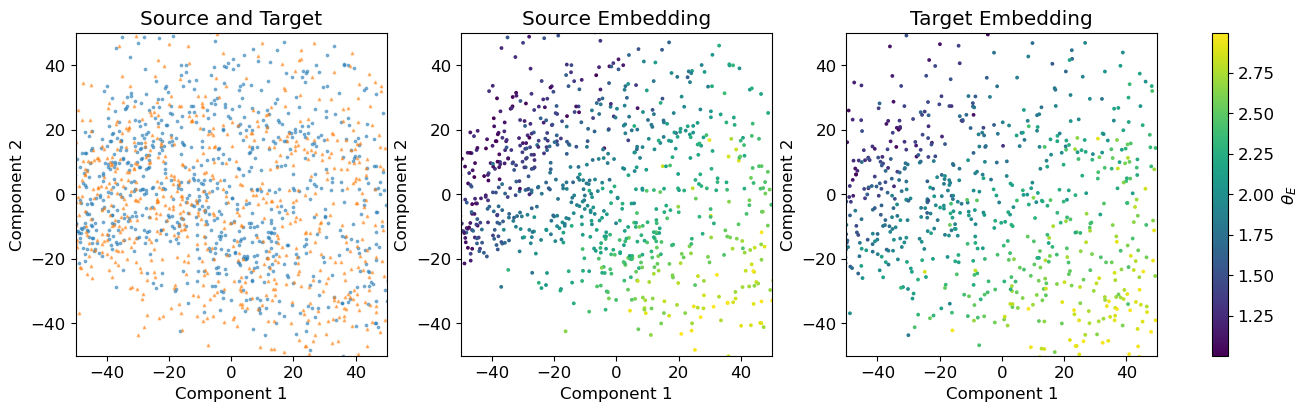


Epoch 140: 60.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2732
	Train Regression Loss: : 0.0030
	Train Mve Loss: : -0.2788
	Train R2 Score: : 0.9907
 Validation Statistics:
	Val Source Regression Loss: : 0.0028
	Val Target Regression Loss: : 0.0231
	Val Source R2 Score: : 0.9914
	Val Target R2 Score: : 0.9308
	Val Source Mve Loss: : -0.3957
	Val Target Mve Loss: : -0.3433
Saving Model MVE... Done.

Epoch 141: 60.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2738
	Train Regression Loss: : 0.0024
	Train Mve Loss: : -0.3767
	Train R2 Score: : 0.9927
 Validation Statistics:
	Val Source Regression Loss: : 0.0026
	Val Target Regression Loss: : 0.0293
	Val Source R2 Score: : 0.9918
	Val Target R2 Score: : 0.9118
	Val Source Mve Loss: : -0.2965
	Val Target Mve Loss: : 0.0483

Epoch 142: 57.87s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2783
	Train Regression Loss: : 0.0023
	Train Mve Loss: : -0.31

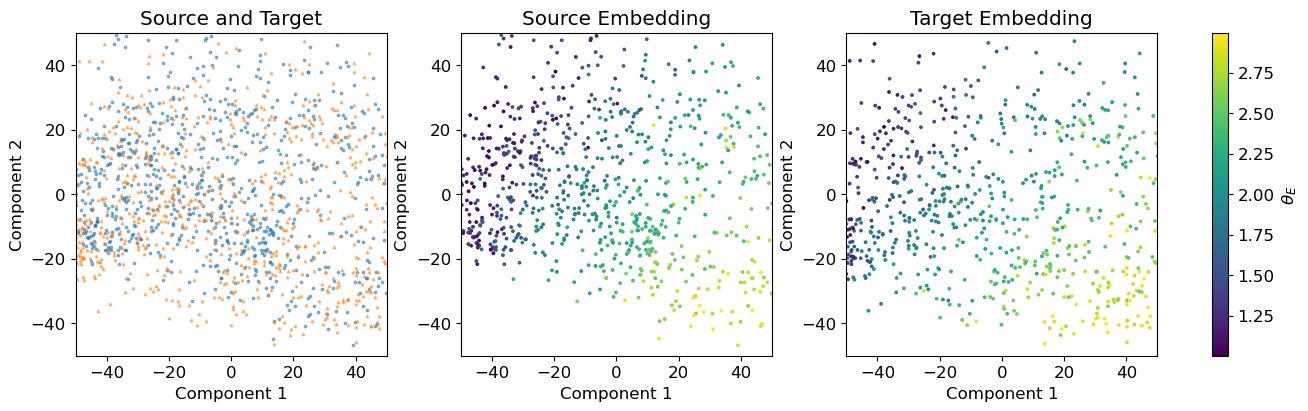


Epoch 160: 69.73s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2660
	Train Regression Loss: : 0.0019
	Train Mve Loss: : -0.3995
	Train R2 Score: : 0.9940
 Validation Statistics:
	Val Source Regression Loss: : 0.0019
	Val Target Regression Loss: : 0.0287
	Val Source R2 Score: : 0.9942
	Val Target R2 Score: : 0.9140
	Val Source Mve Loss: : -0.4544
	Val Target Mve Loss: : -0.2598

Epoch 161: 60.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2669
	Train Regression Loss: : 0.0019
	Train Mve Loss: : -0.3284
	Train R2 Score: : 0.9942
 Validation Statistics:
	Val Source Regression Loss: : 0.0018
	Val Target Regression Loss: : 0.0276
	Val Source R2 Score: : 0.9942
	Val Target R2 Score: : 0.9170
	Val Source Mve Loss: : -0.2663
	Val Target Mve Loss: : 28.0766

Epoch 162: 62.55s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2665
	Train Regression Loss: : 0.0019
	Train Mve Loss: : -0.4491
	Train R2 Score: : 0.9

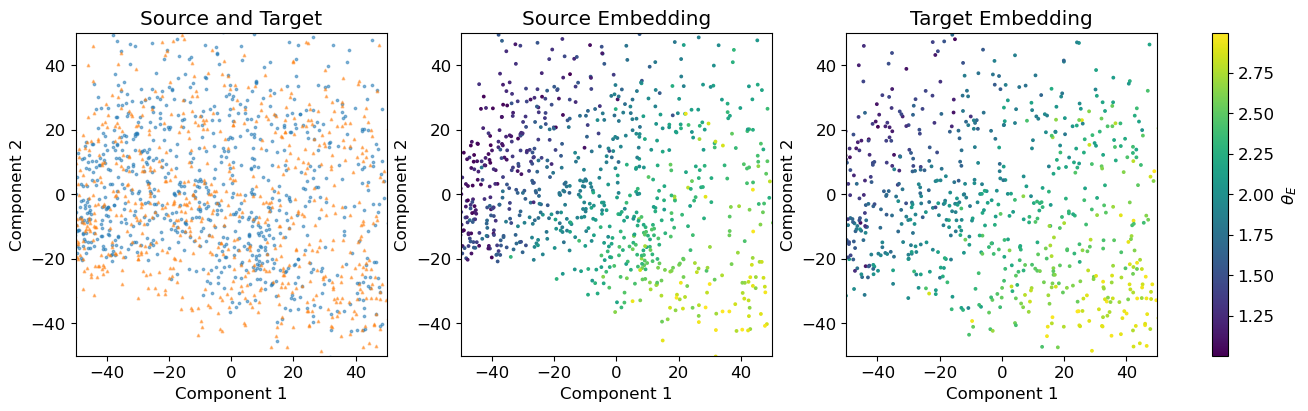


Epoch 180: 63.07s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2537
	Train Regression Loss: : 0.0017
	Train Mve Loss: : -0.4546
	Train R2 Score: : 0.9946
 Validation Statistics:
	Val Source Regression Loss: : 0.0018
	Val Target Regression Loss: : 0.0201
	Val Source R2 Score: : 0.9946
	Val Target R2 Score: : 0.9400
	Val Source Mve Loss: : -0.4245
	Val Target Mve Loss: : 31.3124

Epoch 181: 58.59s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2530
	Train Regression Loss: : 0.0021
	Train Mve Loss: : -0.5495
	Train R2 Score: : 0.9936
 Validation Statistics:
	Val Source Regression Loss: : 0.0018
	Val Target Regression Loss: : 0.0195
	Val Source R2 Score: : 0.9944
	Val Target R2 Score: : 0.9416
	Val Source Mve Loss: : -0.6493
	Val Target Mve Loss: : -0.5692
Saving Model MVE... Done.

Epoch 182: 59.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2523
	Train Regression Loss: : 0.0016
	Train Mve Loss: : -0.6

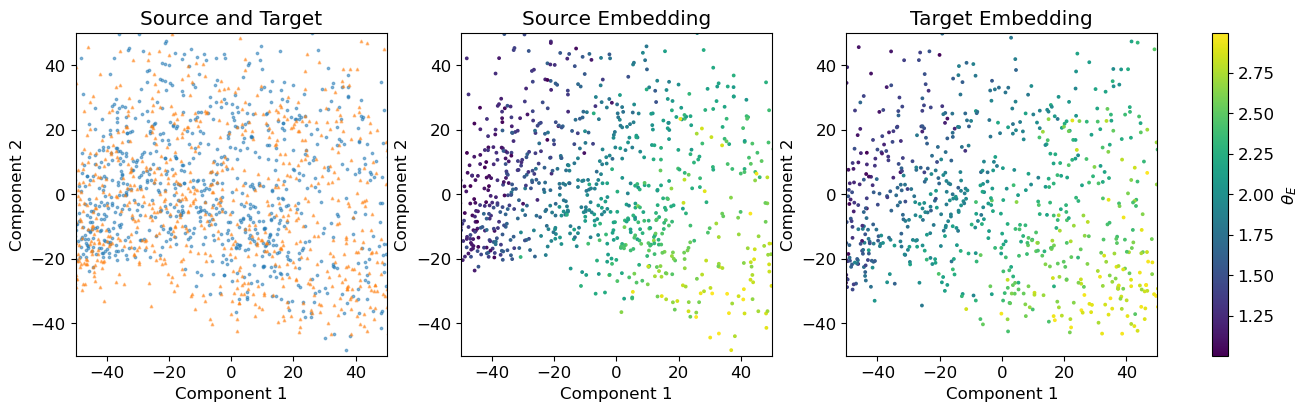

Saving Model MVE... Done.

Epoch 200: 64.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2512
	Train Regression Loss: : 0.0052
	Train Mve Loss: : -0.5922
	Train R2 Score: : 0.9842
 Validation Statistics:
	Val Source Regression Loss: : 0.0044
	Val Target Regression Loss: : 0.0166
	Val Source R2 Score: : 0.9864
	Val Target R2 Score: : 0.9502
	Val Source Mve Loss: : 0.2427
	Val Target Mve Loss: : 1.7972

Epoch 201: 62.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2477
	Train Regression Loss: : 0.0086
	Train Mve Loss: : -0.0873
	Train R2 Score: : 0.9736
 Validation Statistics:
	Val Source Regression Loss: : 0.0126
	Val Target Regression Loss: : 0.0307
	Val Source R2 Score: : 0.9608
	Val Target R2 Score: : 0.9083
	Val Source Mve Loss: : -0.7408
	Val Target Mve Loss: : -0.6652

Epoch 202: 56.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2492
	Train Regression Loss: : 0.0088
	Train Mve Loss: : -0.765

In [ ]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [ ]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

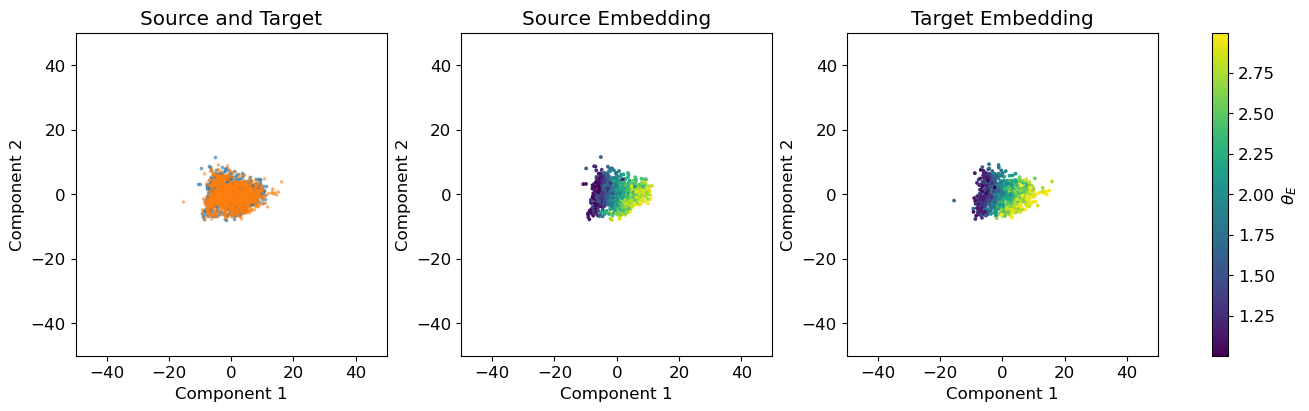

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [11]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

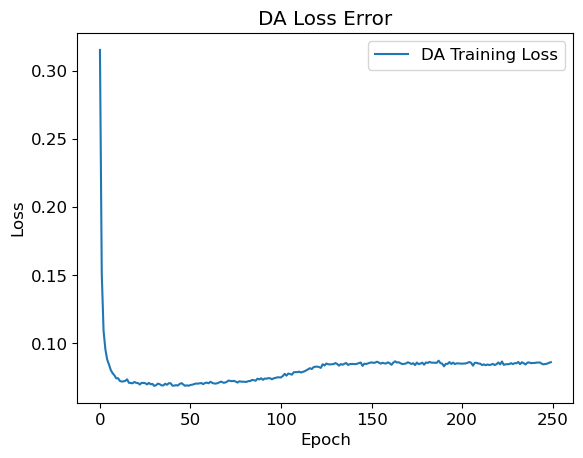

In [12]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

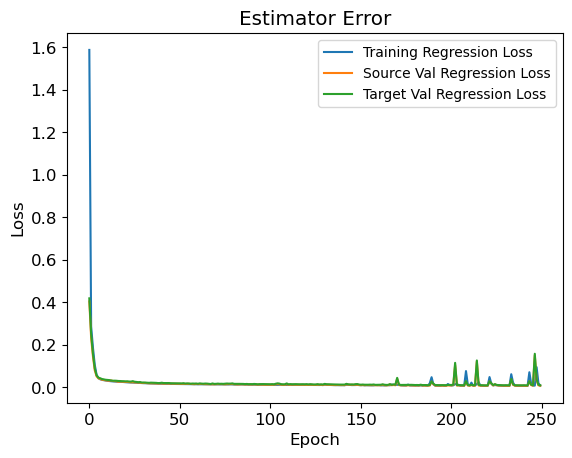

In [13]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

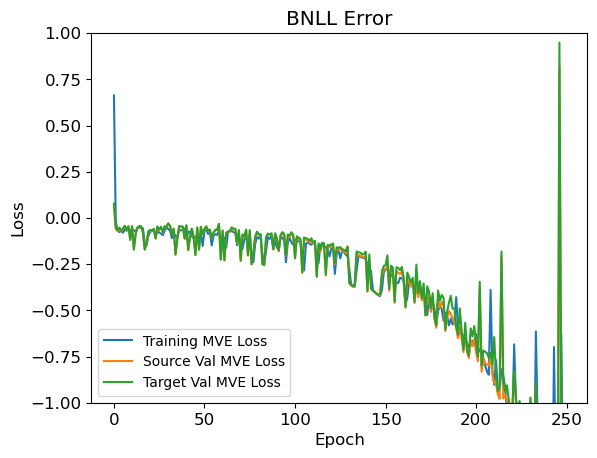

In [14]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

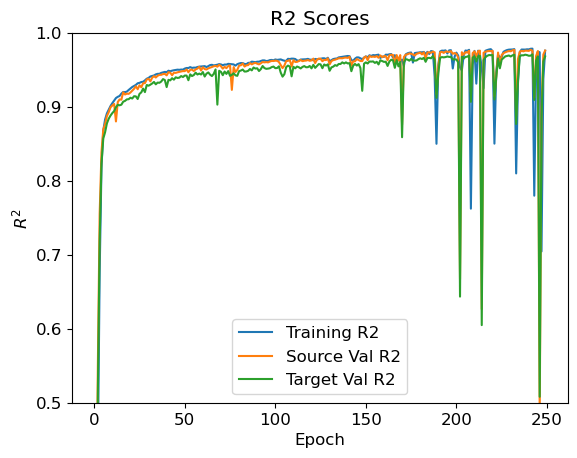

In [15]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [26]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9767


Text(0.5, 1.0, 'MMD | Source | R2: 0.977')

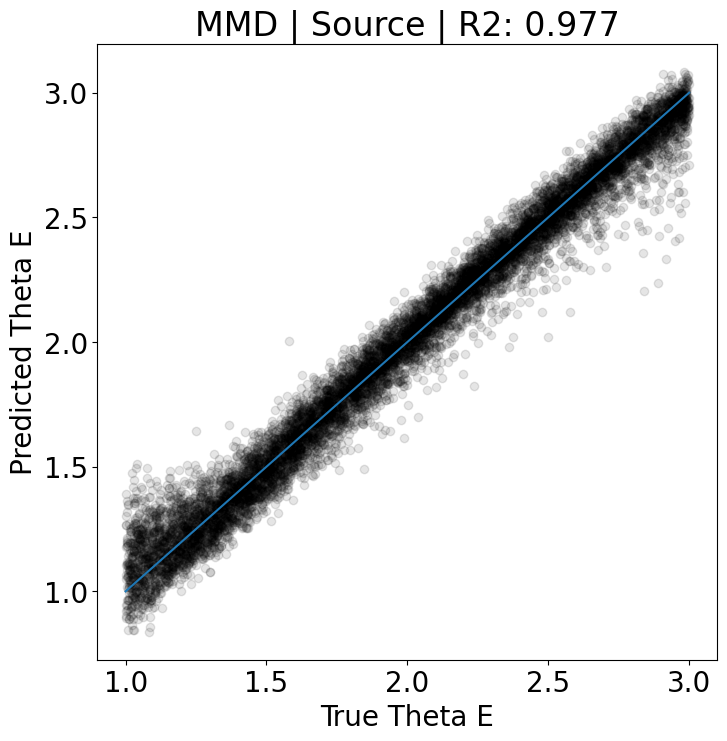

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.175')

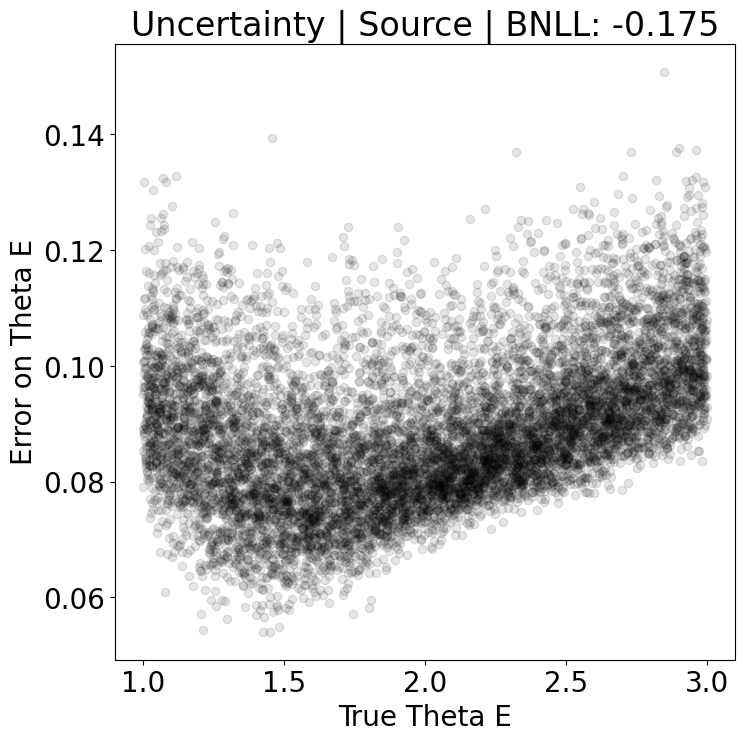

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [29]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9661


Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

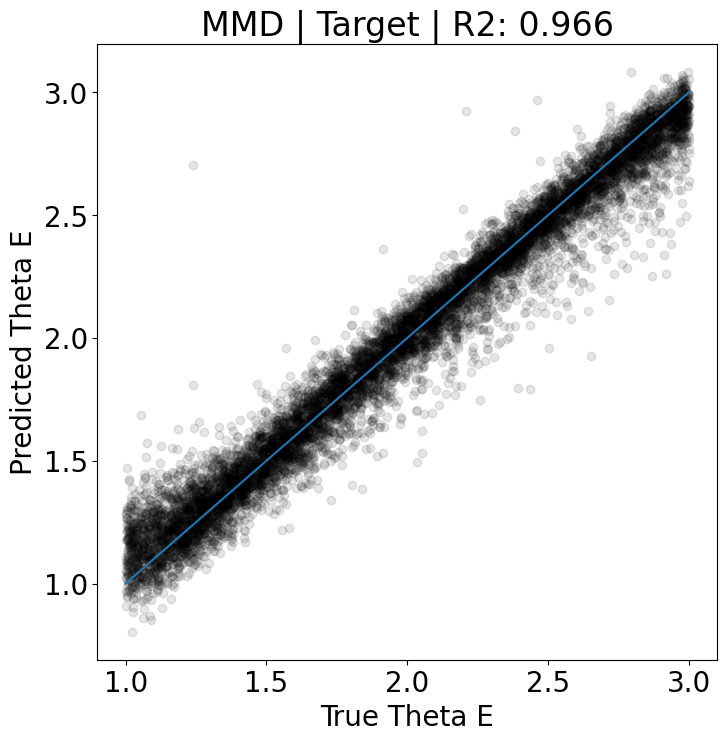

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

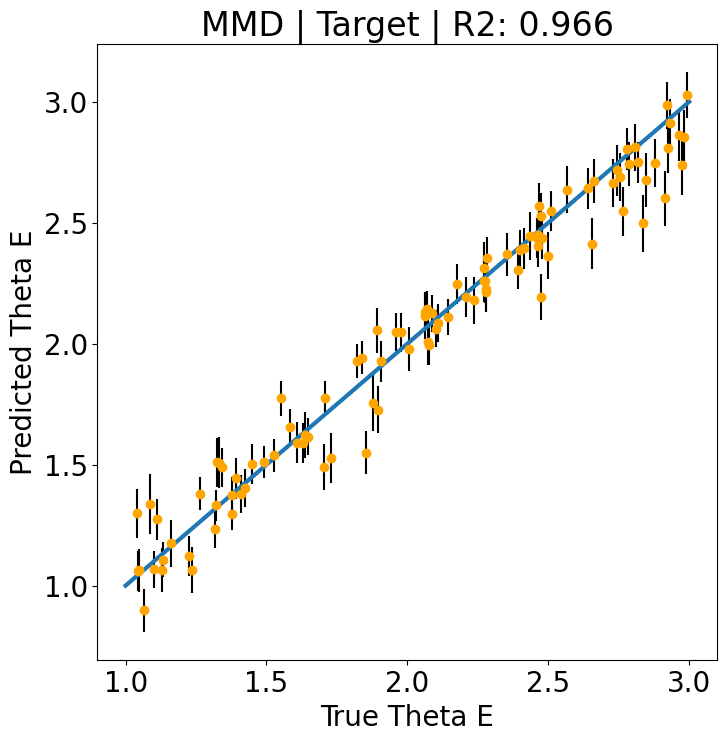

In [31]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.156')

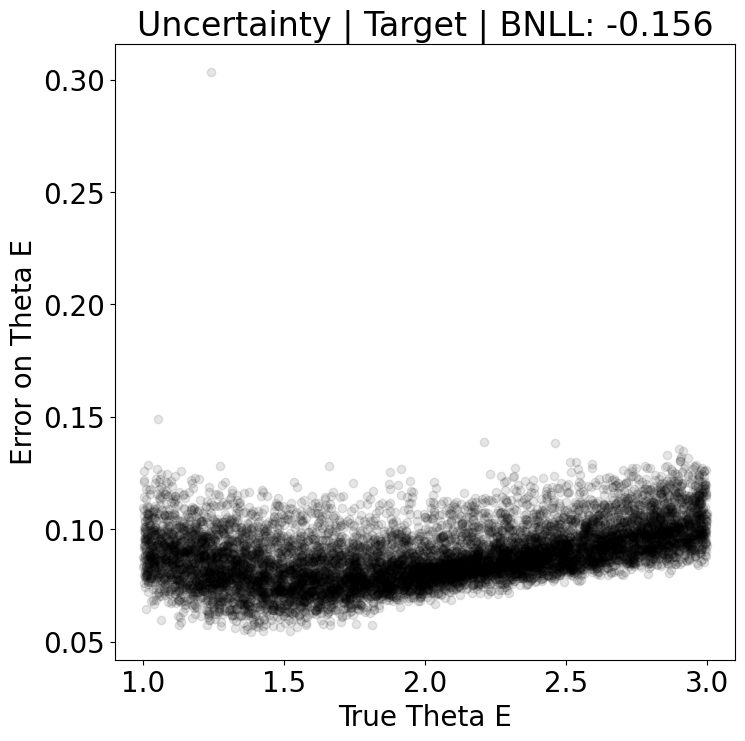

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [33]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

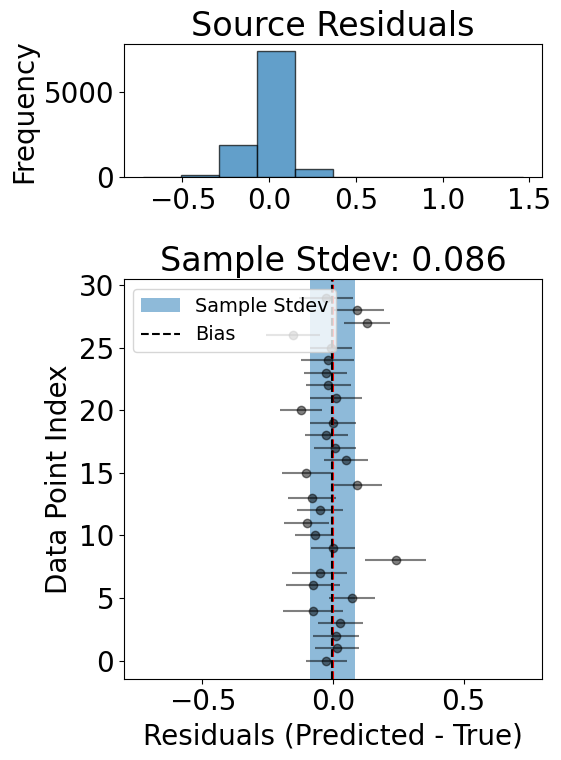

In [34]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

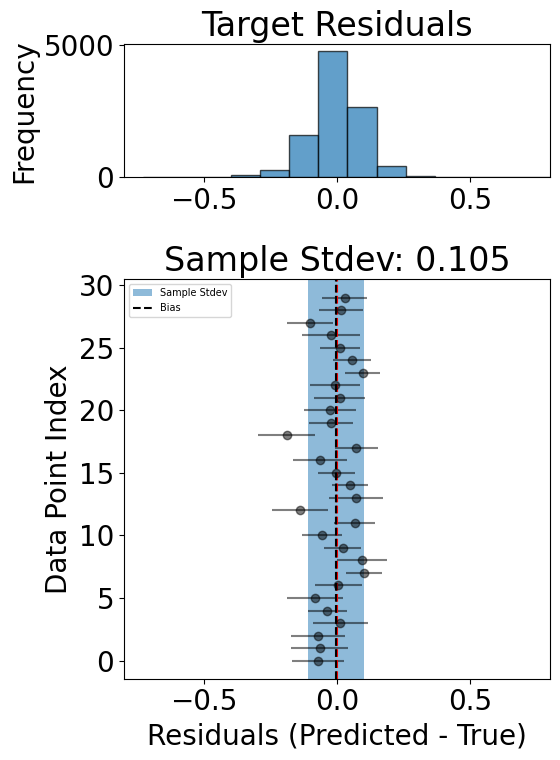

In [38]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()